<h1>libraries and seeds</h1>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageOps
import pickle
import os

# Set seed for reproducibility
SEED = 20
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-14 17:42:08.487659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747244528.766713      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747244528.839768      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1>Data Loader</h1>

In [2]:
class DataLoader:
    def __init__(self, train_size=5000, test_size=10000):
        self.train_size = train_size
        self.test_size = test_size
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.load_data()
    
    def load_data(self):
        # Load and preprocess MNIST
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        
        # Normalization
        x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
        x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0
        
        # One-Hot-Encoding
        y_train = tf.keras.utils.to_categorical(y_train, 10)
        y_test = tf.keras.utils.to_categorical(y_test, 10)
        
        # Training Set
        self.x_train = x_train[:self.train_size]
        self.y_train = y_train[:self.train_size]
        
        # Testing Set
        self.x_test = x_test[:self.test_size]
        self.y_test = y_test[:self.test_size]
    
    def get_data(self):
        return self.x_train, self.y_train, self.x_test, self.y_test
    
    def get_samples(self, num_samples=5):
        # Get random samples for visualization 
        indices = np.random.choice(len(self.x_test), num_samples, replace=False)
        return self.x_test[indices], self.y_test[indices], indices

<h1>Neural Network</h1>

In [3]:
class NeuralNetwork:
    def __init__(self, input_dim=784, hidden_dim=32, output_dim=10):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.vector_size = input_dim * hidden_dim + hidden_dim + hidden_dim * output_dim + output_dim
        self.initialize_weights()
    
    def initialize_weights(self):
        # Initialize the model’s parameters inside the class, so that they can be used during forward or backward passes.
        self.W1 = np.random.randn(self.input_dim, self.hidden_dim) * np.sqrt(2 / self.input_dim)
        self.b1 = np.zeros(self.hidden_dim)
        self.W2 = np.random.randn(self.hidden_dim, self.output_dim) * np.sqrt(2 / self.hidden_dim)
        self.b2 = np.zeros(self.output_dim)
    
    def he_vector(self):
        """Generate a vector using He initialization"""
        # Generate a vector representing a possible solution (for optimization algorithms like Genetic Algorithms, Differential Evolution, etc.)
        w1 = np.random.randn(self.input_dim, self.hidden_dim) * np.sqrt(2 / self.input_dim)
        b1 = np.zeros(self.hidden_dim)
        w2 = np.random.randn(self.hidden_dim, self.output_dim) * np.sqrt(2 / self.hidden_dim)
        b2 = np.zeros(self.output_dim)
        return np.concatenate([w1.flatten(), b1, w2.flatten(), b2])
    
    def decode_vector(self, vector):
        """Decode a flat vector into the network weights"""
        W1 = vector[0:self.input_dim * self.hidden_dim].reshape((self.input_dim, self.hidden_dim))
        b1 = vector[self.input_dim * self.hidden_dim:self.input_dim * self.hidden_dim + self.hidden_dim].reshape((self.hidden_dim,))
        W2 = vector[self.input_dim * self.hidden_dim + self.hidden_dim:self.input_dim * self.hidden_dim + self.hidden_dim + self.hidden_dim * self.output_dim].reshape((self.hidden_dim, self.output_dim))
        b2 = vector[self.input_dim * self.hidden_dim + self.hidden_dim + self.hidden_dim * self.output_dim:].reshape((self.output_dim,))
        return W1, b1, W2, b2
    
    def set_weights_from_vector(self, vector):
        """Set the network weights from a flat vector"""
        self.W1, self.b1, self.W2, self.b2 = self.decode_vector(vector)
    
    def get_weights_as_vector(self):
        """Convert the network weights to a flat vector"""
        return np.concatenate([self.W1.flatten(), self.b1, self.W2.flatten(), self.b2])
    
    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)
    
    def softmax(self, x):
        """Softmax activation function with numerical stability"""
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Forward pass through the network (for backpropagation)"""  
        Z1 = X @ self.W1 + self.b1      # Linear part
        A1 = self.relu(Z1)              # Apply ReLU
        Z2 = A1 @ self.W2 + self.b2     # Linear part
        A2 = self.softmax(Z2)           # Apply softmax
        return A2, A1, Z1
    
    def forward_from_vector(self, X, vector):
        """Forward pass using weights from a vector (for EA)"""
        W1, b1, W2, b2 = self.decode_vector(vector)
        Z1 = X @ W1 + b1      # Linear part
        A1 = self.relu(Z1)    # Apply ReLU
        Z2 = A1 @ W2 + b2     # Linear part
        A2 = self.softmax(Z2) # Apply softmax
        return A2
    
    def cross_entropy(self, preds, targets, eps=1e-12):
        """Compute cross-entropy loss"""
        preds = np.clip(preds, eps, 1 - eps)  # Avoid log(0) and log(1)
        return -np.mean(np.sum(targets * np.log(preds), axis=1))
    
    def predict(self, X):
        """Make predictions for input data"""
        probs, _, _ = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def evaluate(self, X, y):
        """Evaluate model performance"""
        probs, _, _ = self.forward(X)
        loss = self.cross_entropy(probs, y)
        y_pred = np.argmax(probs, axis=1)
        y_true = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred == y_true)
        return loss, accuracy
    
    def fitness_function(self, vector, x_data, y_data):
        """Compute the fitness (loss) for a given weight vector"""
        probs = self.forward_from_vector(x_data, vector)
        ce_loss = self.cross_entropy(probs, y_data)
        return ce_loss
    
    def save_model(self, filename):
        """Save the model weights to a file"""
        model_data = {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2,
            'input_dim': self.input_dim,
            'hidden_dim': self.hidden_dim,
            'output_dim': self.output_dim
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
    
    @classmethod
    def load_model(cls, filename):
        """Load a model from a file"""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        
        model = cls(
            input_dim=model_data['input_dim'],
            hidden_dim=model_data['hidden_dim'],
            output_dim=model_data['output_dim']
        )
        
        model.W1 = model_data['W1']
        model.b1 = model_data['b1']
        model.W2 = model_data['W2']
        model.b2 = model_data['b2']
        
        return model

<h1>Visualizer</h1>

In [ ]:
class Visualizer:
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader = data_loader
    
    def display_results_table(self, results):
        """Display a table with performance metrics"""
        table_data = {
            'Metric': ['Best Loss', 'Final Loss', 'Final Test Accuracy', 'Total Iterations', 'Execution Time (s)'],
            'Value': [
                f"{results['best_loss']:.4f}",
                f"{results['final_loss']:.4f}",
                f"{results['final_accuracy']:.4f}",
                f"{results['total_iterations']}",
                f"{results['execution_time']:.2f}"
            ]
        }
        
        print("\nPerformance Summary:")
        print("-" * 40)
        for i in range(len(table_data['Metric'])):
            print(f"{table_data['Metric'][i]:<20}: {table_data['Value'][i]}")
        print("-" * 40)
        
        return table_data
    
    def plot_training_progress(self, history):
        """Plot the training progress (loss and accuracy)"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Loss over Iterations')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracy
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Accuracy over Iterations')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self):
        """Plot the confusion matrix for the test data"""
        _, _, x_test, y_test = self.data_loader.get_data()
        y_pred = self.model.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def display_classification_report(self):
        """Display the classification report"""
        _, _, x_test, y_test = self.data_loader.get_data()
        y_pred = self.model.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        
        report = classification_report(y_true, y_pred, digits=4)
        
        # Create a DataFrame for visualization
        report_data = classification_report(y_true, y_pred, digits=4, output_dict=True)
        df_report = pd.DataFrame(report_data).transpose()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_report.iloc[:-3, :].astype(float), annot=True, cmap='Blues')
        plt.title('Classification Report')
        plt.tight_layout()
        plt.show()


    def display_samples(self, num_samples=5):
        """Display sample images with actual and predicted labels"""
        x_samples, y_samples, indices = self.data_loader.get_samples(num_samples)
        y_true = np.argmax(y_samples, axis=1)
        y_pred = self.model.predict(x_samples)
        
        plt.figure(figsize=(15, 3))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(x_samples[i].reshape(28, 28), cmap='gray')
            plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_all(self, results):
        """Run all visualization methods"""
        self.display_results_table(results)
        self.plot_training_progress(results['history'])
        self.plot_confusion_matrix()
        self.display_classification_report()
        # self.visualize_population_distribution(results['history'].get('population_states', []))
        self.display_samples()

<h1>BP</h1>

In [5]:
class Backpropagation:
    def __init__(self, model, data_loader, learning_rate=0.01, batch_size=32, epochs=50):
        self.model = model
        self.data_loader = data_loader
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }
    
    def train(self):
        start_time = time.time()
        
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        n_samples = len(x_train)
        n_batches = int(np.ceil(n_samples / self.batch_size))
        
        print(f"Starting Backpropagation training for {self.epochs} epochs...")
        
        for epoch in range(self.epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            x_shuffled = x_train[indices]
            y_shuffled = y_train[indices]
            
            epoch_loss = 0
            
            for batch in range(n_batches):
                # Get batch data
                start_idx = batch * self.batch_size
                end_idx = min((batch + 1) * self.batch_size, n_samples)
                x_batch = x_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                batch_size = end_idx - start_idx
                
                # Forward pass
                y_pred, hidden_output, hidden_input = self.model.forward(x_batch)
                batch_loss = self.model.cross_entropy(y_pred, y_batch)
                epoch_loss += batch_loss * batch_size
                
                # Backpropagation
                # Output layer error
                delta2 = y_pred - y_batch
                
                # Hidden layer error
                delta1 = (delta2 @ self.model.W2.T) * (hidden_output > 0)
                
                # Gradients
                dW2 = hidden_output.T @ delta2 / batch_size
                db2 = np.sum(delta2, axis=0) / batch_size
                dW1 = x_batch.T @ delta1 / batch_size
                db1 = np.sum(delta1, axis=0) / batch_size
                
                # Update weights
                self.model.W2 -= self.learning_rate * dW2
                self.model.b2 -= self.learning_rate * db2
                self.model.W1 -= self.learning_rate * dW1
                self.model.b1 -= self.learning_rate * db1
            
            # Calculate epoch metrics
            epoch_loss /= n_samples
            
            # Evaluate on training data
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{self.epochs} - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.epochs,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [6]:
def run_backpropagation():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the Backpropagation algorithm"""
    print("Running Neural Network with Backpropagation...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize backpropagation trainer
    bp_trainer = Backpropagation(model, data_loader, learning_rate=0.01, batch_size=32, epochs=50)
    
    # Train the model
    results = bp_trainer.train()
    
    # Save the model
    model.save_model('bp_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Backpropagation...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Starting Backpropagation training for 50 epochs...
Epoch 1/50 - loss: 1.3797 - accuracy: 0.6816 - val_loss: 1.3776 - val_accuracy: 0.6719
Epoch 5/50 - loss: 0.5004 - accuracy: 0.8806 - val_loss: 0.5295 - val_accuracy: 0.8662
Epoch 10/50 - loss: 0.3554 - accuracy: 0.9136 - val_loss: 0.4019 - val_accuracy: 0.8880
Epoch 15/50 - loss: 0.3012 - accuracy: 0.9220 - val_loss: 0.3596 - val_accuracy: 0.8969
Epoch 20/50 - loss: 0.2698 - accuracy: 0.9310 - val_loss: 0.3392 - val_accuracy: 0.9015
Epoch 25/50 - loss: 0.2459 - accuracy: 0.9358 - val_loss: 0.3262 - val_accuracy: 0.9040
Epoch 30/50 - loss: 0.2289 - accuracy: 0.9388 - val_loss: 0.3180 - val_accuracy: 0.9074
Epoch 35/50 - loss: 0.2132 - accuracy: 0.9428 - val_loss: 0.3115 - val_accuracy: 0.9075
Epoch 40/50 - loss: 0.1999 - accuracy: 0.9470 - val_loss: 0.3053 - val_accuracy: 0.9089
Epoch 45/50 - loss: 0.1872 - accuracy: 0.9498 - val_loss: 0.3

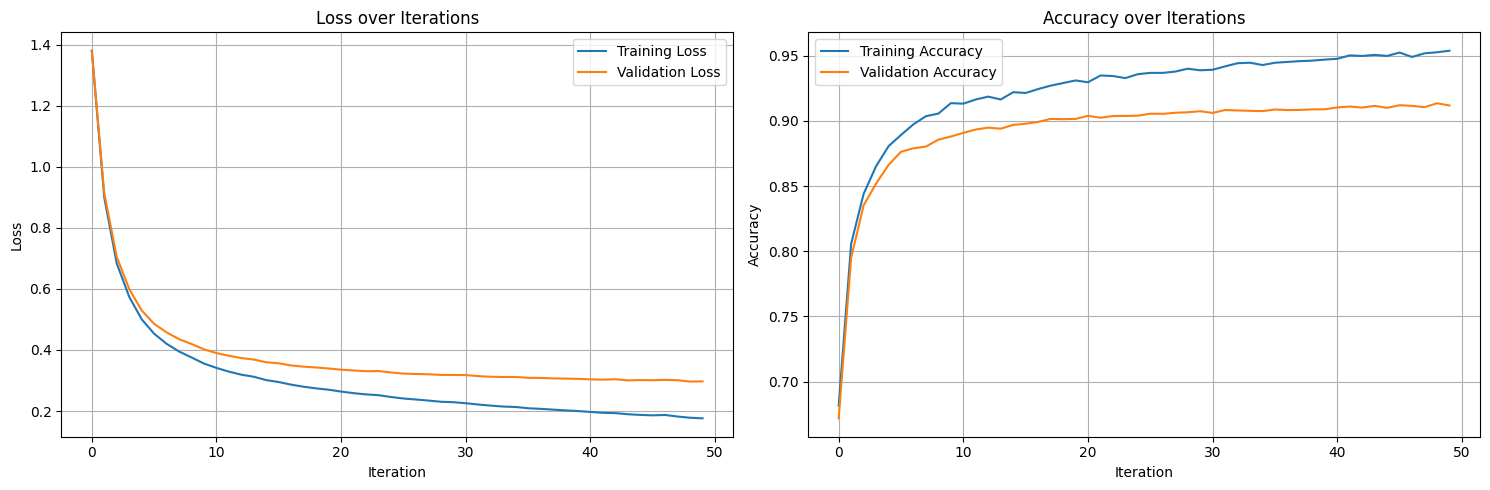

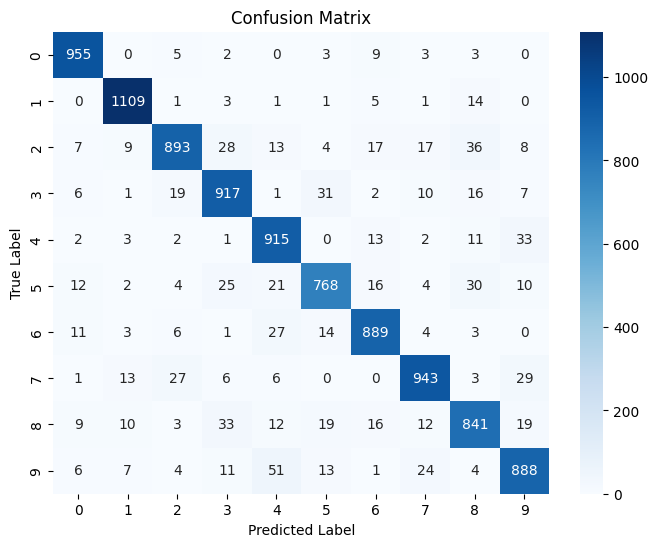

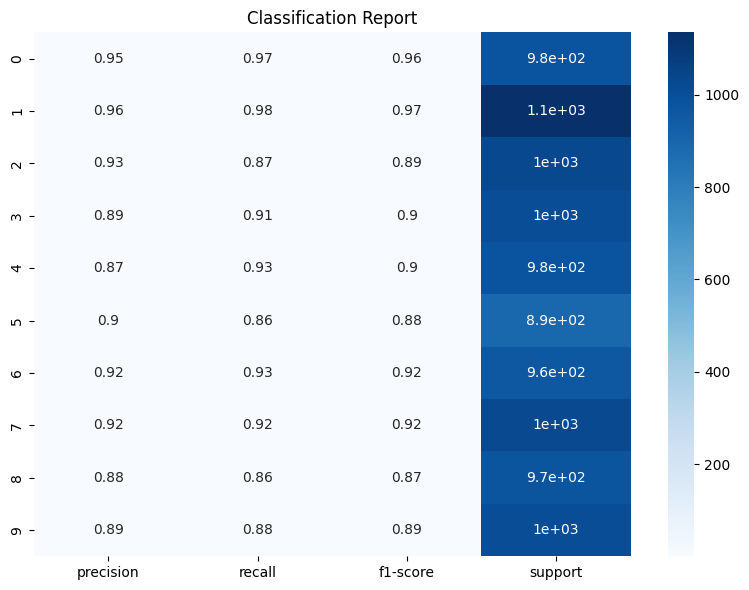

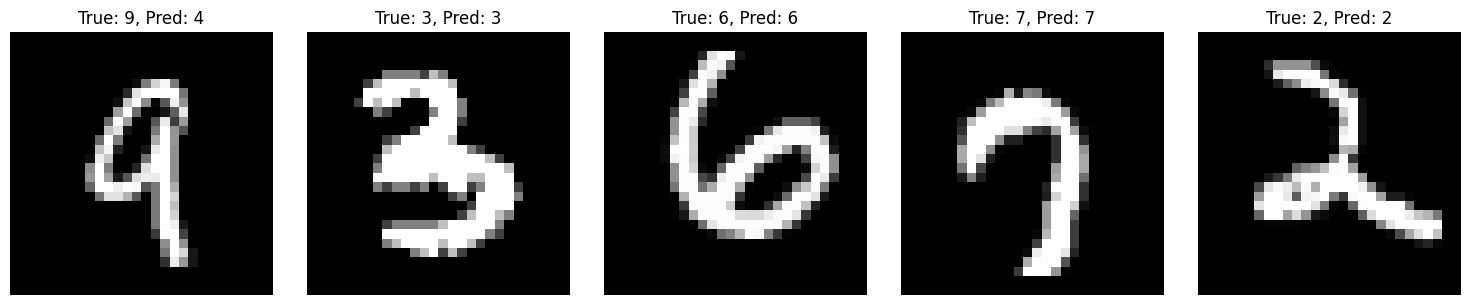

(<__main__.NeuralNetwork at 0x7fdf43d09bd0>,
 {'best_loss': 0.29641301166289896,
  'final_loss': 0.2970221241169259,
  'final_accuracy': 0.9118,
  'total_iterations': 50,
  'execution_time': 6.30874228477478,
  'history': {'loss': [1.3797285244167539,
    0.8985390011299526,
    0.6833639434825481,
    0.5740838519746787,
    0.5003776394916245,
    0.4531390609079246,
    0.4200862300111908,
    0.39483328521428646,
    0.3754218319418134,
    0.3553927622438326,
    0.34114362429338696,
    0.3289698307285582,
    0.3189437514868767,
    0.3121494054559675,
    0.30120592658981726,
    0.2948477632554176,
    0.2863115661126195,
    0.2794678405449267,
    0.27410039299488975,
    0.2697590708498718,
    0.2637445647261624,
    0.25842287736045044,
    0.25445406904989654,
    0.2517855566096214,
    0.2459471424416693,
    0.2409304836875668,
    0.2377001874866849,
    0.23423385014650386,
    0.23037527692020457,
    0.22890071607385654,
    0.22556528833826195,
    0.221265340315

In [7]:
run_backpropagation()

<h1>DE</h1>

In [8]:
class DifferentialEvolution:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, F=0.5, CR=0.7, initial_population=None, initial_fitness=None):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.F = F
        self.CR = CR
        self.dim = model.vector_size
        self.population = initial_population
        self.fitness = initial_fitness
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population
        if self.population is None or self.fitness is None:
            population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
            fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        else:
            population = np.array(self.population)
            fitness = np.array(self.fitness)
        
        print(f"Starting Differential Evolution for {self.generations} generations...")
        
        for gen in range(self.generations):
            # To store offsprings
            new_pop = np.zeros_like(population)
            new_fit = np.zeros(self.pop_size)
            
            for i in range(self.pop_size):
                # Parent Selection
                idxs = np.delete(np.arange(self.pop_size), i)  # Target Vector
                
                # current/1 Mutation
                v1, v2, v3 = population[np.random.choice(idxs, 3, replace=False)]
                mutant = v1 + self.F * (v2 - v3)  # Mutant Vector
                
                # Crossover
                cross_points = np.random.rand(self.dim) < self.CR
                if not np.any(cross_points):
                    cross_points[np.random.randint(self.dim)] = True
                
                trial = np.where(cross_points, mutant, population[i])
                trial_fitness = self.model.fitness_function(trial, x_train, y_train)
                
                # Survivor Selection
                if trial_fitness <= fitness[i]:
                    new_pop[i] = trial
                    new_fit[i] = trial_fitness
                else:
                    new_pop[i] = population[i]
                    new_fit[i] = fitness[i]
            
            population = np.array(new_pop)
            fitness = np.array(new_fit)
            
            # Find best solution
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [9]:
def run_differential_evolution(initial_population=None, initial_fitness=None):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the Differential Evolution algorithm"""
    print("Running Neural Network with Differential Evolution optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize DE optimizer
    de_optimizer = DifferentialEvolution(model, data_loader, pop_size=20, generations=3000, F=0.5, CR=0.7, initial_population=initial_population, initial_fitness=initial_fitness)
    
    # Train the model
    results = de_optimizer.train()
    
    # Save the model
    model.save_model('de_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Differential Evolution optimization...
Starting Differential Evolution for 3000 generations...
Generation 1/3000 - Best loss: 2.3459 - Accuracy: 0.1269
Generation 101/3000 - Best loss: 2.1511 - Accuracy: 0.2619
Generation 201/3000 - Best loss: 2.1258 - Accuracy: 0.2403
Generation 301/3000 - Best loss: 1.9903 - Accuracy: 0.3306
Generation 401/3000 - Best loss: 1.8987 - Accuracy: 0.3955
Generation 501/3000 - Best loss: 1.6912 - Accuracy: 0.4358
Generation 601/3000 - Best loss: 1.4358 - Accuracy: 0.5415
Generation 701/3000 - Best loss: 1.2550 - Accuracy: 0.5866
Generation 801/3000 - Best loss: 1.0657 - Accuracy: 0.6439
Generation 901/3000 - Best loss: 0.9393 - Accuracy: 0.6863
Generation 1001/3000 - Best loss: 0.8289 - Accuracy: 0.7098
Generation 1101/3000 - Best loss: 0.7293 - Accuracy: 0.7486
Generation 1201/3000 - Best loss: 0.6691 - Accuracy: 0.7653
Generation 1301/3000 - Best loss: 0.6153 - Accuracy: 0.7788
Generation 1401/3000 - Best loss: 0.5748 - Accura

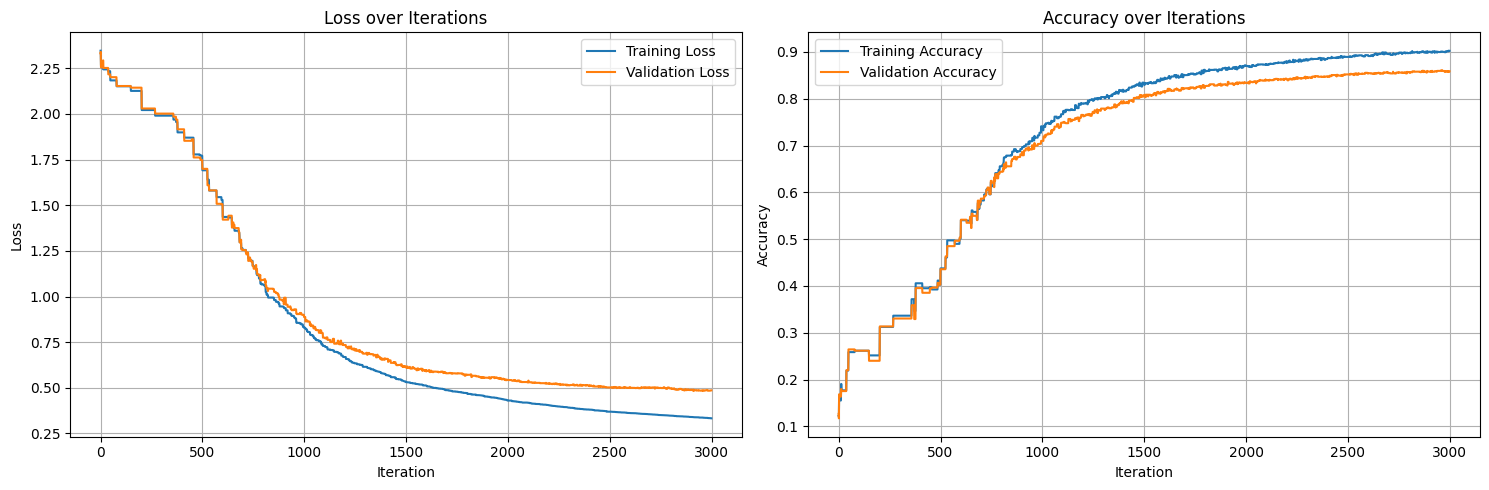

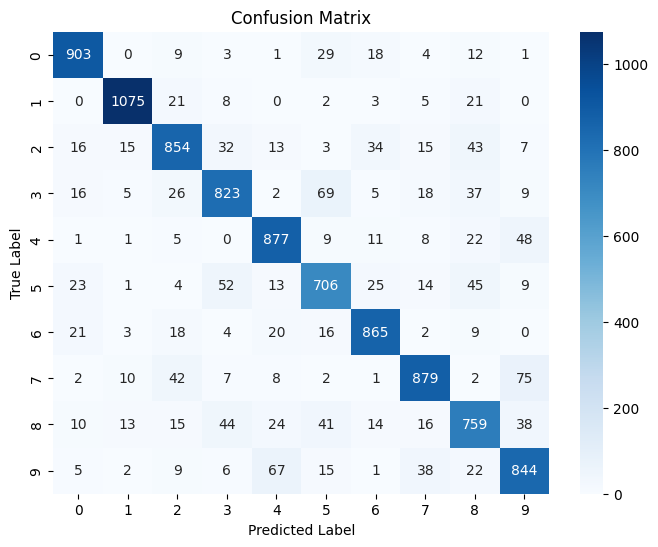

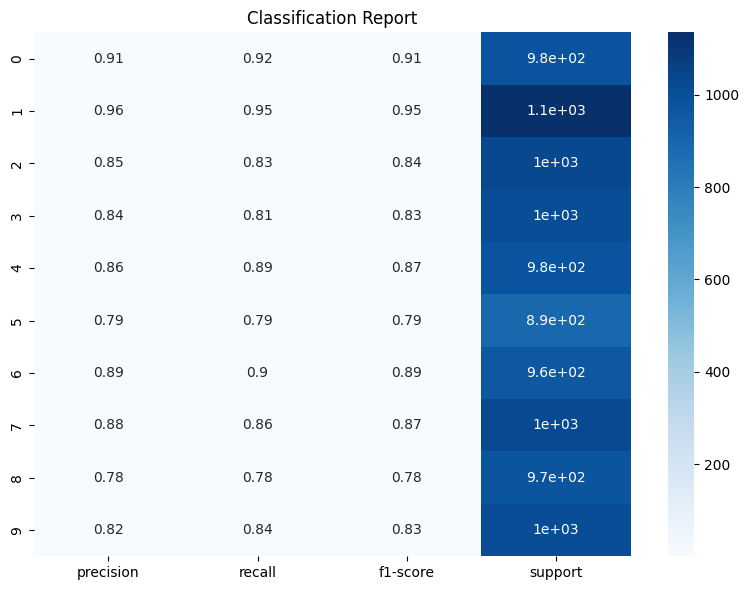

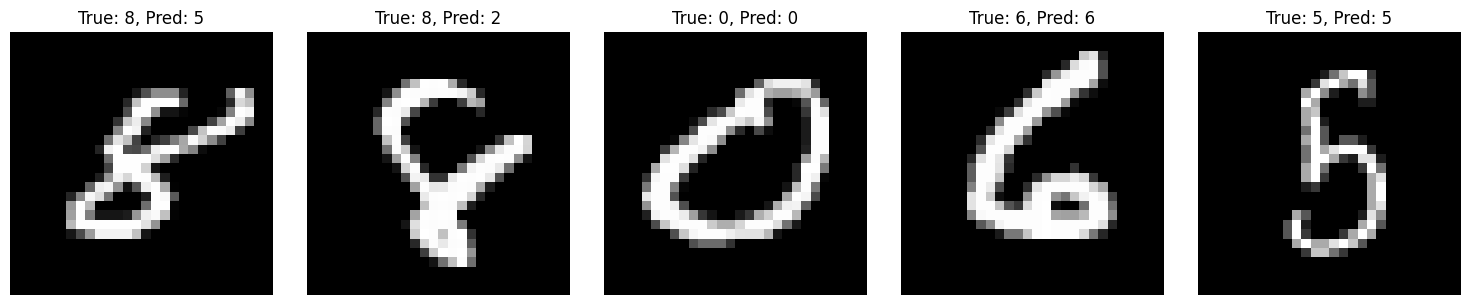

(<__main__.NeuralNetwork at 0x7fdf414da3d0>,
 {'best_loss': 0.48390258331962366,
  'final_loss': 0.4860857170518393,
  'final_accuracy': 0.8585,
  'total_iterations': 3000,
  'execution_time': 1114.7354640960693,
  'history': {'loss': [2.3458542942186336,
    2.3326667923475606,
    2.2653642839210444,
    2.2653642839210444,
    2.2653642839210444,
    2.2653642839210444,
    2.2539705489846984,
    2.2539705489846984,
    2.2539705489846984,
    2.2539705489846984,
    2.2539705489846984,
    2.2539705489846984,
    2.247602840167018,
    2.247602840167018,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.243722038812988,
    2.24372203881298

In [10]:
run_differential_evolution()

<h1>JADE</h1>

In [11]:
class JADE:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, p=0.2, c=0.05):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.p = p
        self.c = c
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population using He initialization
        population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
        fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        archive = []
        mu_F, mu_CR = 0.5, 0.5  # Initial means
        
        print(f"Starting JADE optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            successful_F, successful_CR, deltas = [], [], []
            
            sorted_indices = np.argsort(fitness)
            p_num = max(2, int(self.p * self.pop_size))
            top_indices = sorted_indices[:p_num]
            
            for i in range(self.pop_size):
                # Sample F (mutation factor) from a Cauchy distribution
                F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                while F <= 0:  # Ensure F > 0
                    F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                
                # Sample CR (crossover rate) from a normal distribution
                CR = np.clip(np.random.normal(mu_CR, 0.1), 0, 1)
                
                # Select p-best individual
                pbest = population[np.random.choice(top_indices)]
                
                # Select r1 and r2
                r1 = np.random.choice(np.delete(np.arange(self.pop_size), i))
                
                merged = np.vstack([population, archive]) if len(archive) > 0 else population
                r2_index = np.random.randint(0, len(merged))
                r2 = merged[r2_index]
                
                x_i, x_r1, x_r2 = population[i], population[r1], r2
                
                # Mutation: current-to-pbest
                v = x_i + F * (pbest - x_i) + F * (x_r1 - x_r2)
                
                # Crossover
                cross_mask = np.random.rand(self.dim) < CR
                if not np.any(cross_mask):
                    cross_mask[np.random.randint(self.dim)] = True
                u = np.where(cross_mask, v, x_i)
                
                # Selection
                fit_u = self.model.fitness_function(u, x_train, y_train)
                if fit_u <= fitness[i]:
                    archive.append(population[i].copy())
                    if len(archive) > self.pop_size:
                        archive.pop(np.random.randint(len(archive)))
                    
                    population[i] = u
                    deltas.append(abs(fitness[i] - fit_u))
                    fitness[i] = fit_u
                    successful_F.append(F)
                    successful_CR.append(CR)
            
            # Adapt mu_F and mu_CR using successful values
            if successful_F:
                weights = np.array(deltas) / np.sum(deltas)
                F_array = np.array(successful_F)
                mu_F = (1 - self.c) * mu_F + self.c * np.sum(weights * F_array ** 2) / np.sum(weights * F_array)
            
            if successful_CR:
                mu_CR = (1 - self.c) * mu_CR + self.c * np.mean(successful_CR)
            
            # Log best loss every generation
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [12]:
def run_jade():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the JADE algorithm"""
    print("Running Neural Network with JADE optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize JADE optimizer
    jade_optimizer = JADE(model, data_loader, pop_size=20, generations=3000, p=0.2, c=0.05)
    
    # Train the model
    results = jade_optimizer.train()
    
    # Save the model
    model.save_model('jade_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with JADE optimization...
Starting JADE optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.3138 - Accuracy: 0.0799
Generation 101/3000 - Best loss: 1.4072 - Accuracy: 0.5239
Generation 201/3000 - Best loss: 1.0167 - Accuracy: 0.6622
Generation 301/3000 - Best loss: 0.8096 - Accuracy: 0.7332
Generation 401/3000 - Best loss: 0.7001 - Accuracy: 0.7579
Generation 501/3000 - Best loss: 0.6192 - Accuracy: 0.7824
Generation 601/3000 - Best loss: 0.5620 - Accuracy: 0.7983
Generation 701/3000 - Best loss: 0.5068 - Accuracy: 0.8181
Generation 801/3000 - Best loss: 0.4727 - Accuracy: 0.8273
Generation 901/3000 - Best loss: 0.4457 - Accuracy: 0.8383
Generation 1001/3000 - Best loss: 0.4228 - Accuracy: 0.8428
Generation 1101/3000 - Best loss: 0.4035 - Accuracy: 0.8508
Generation 1201/3000 - Best loss: 0.3895 - Accuracy: 0.8539
Generation 1301/3000 - Best loss: 0.3718 - Accuracy: 0.8560
Generation 1401/3000 - Best loss: 0.3607 - Accuracy: 0.8570
Generation 1

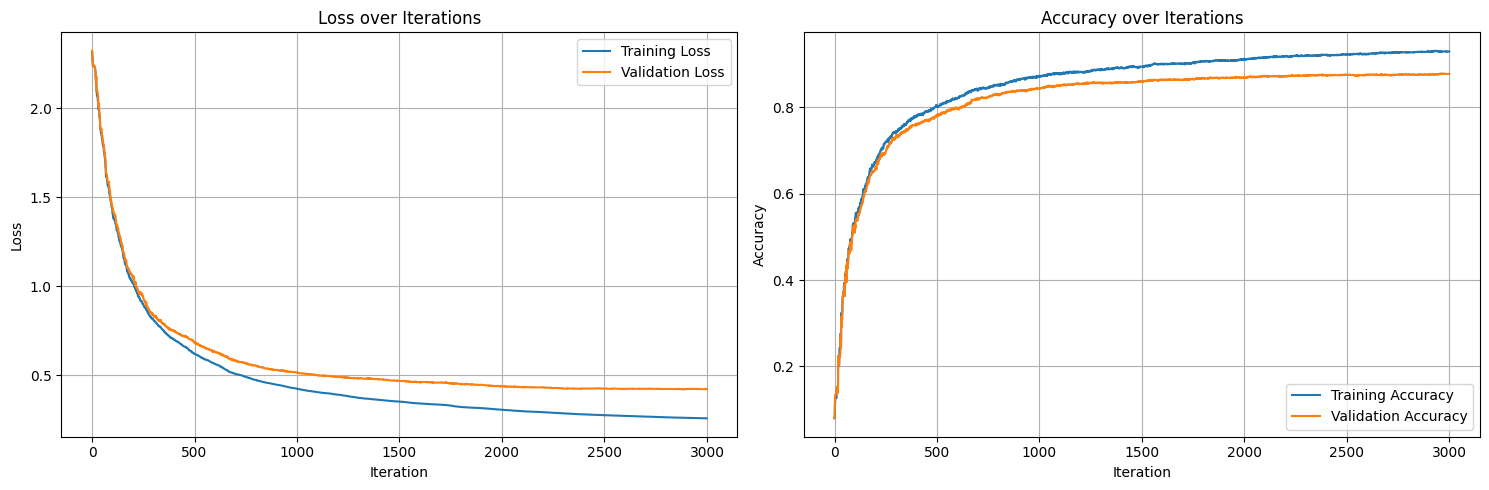

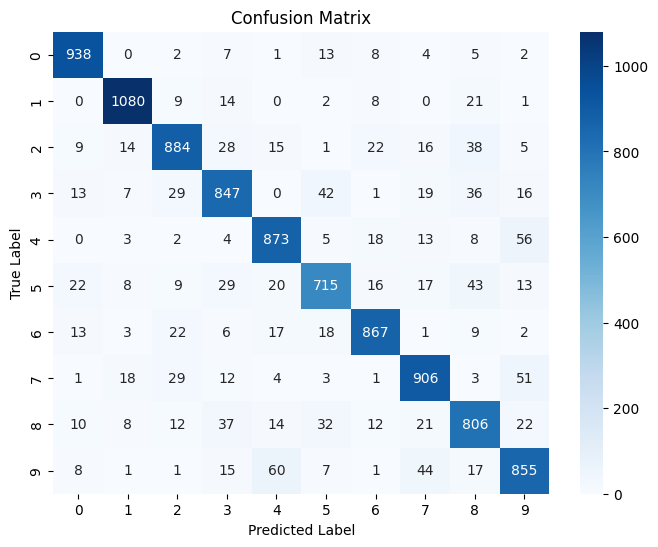

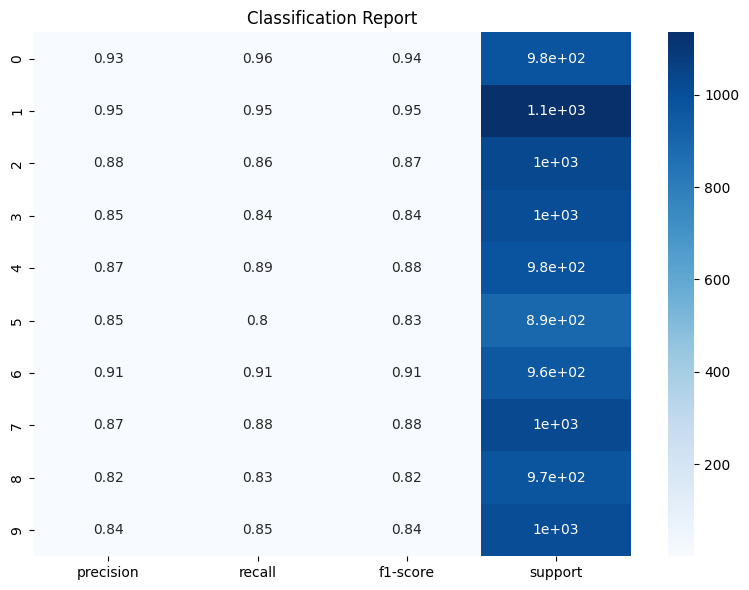

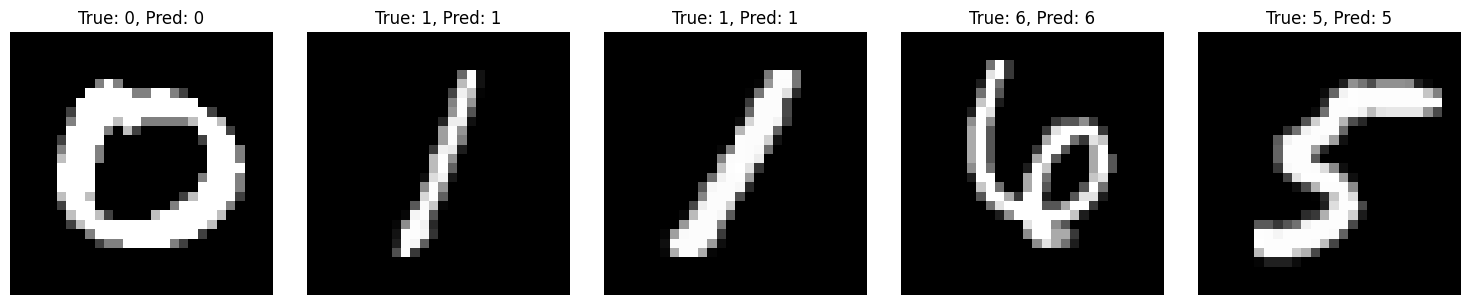

(<__main__.NeuralNetwork at 0x7fdf4029bcd0>,
 {'best_loss': 0.4191973458650391,
  'final_loss': 0.4207497472187484,
  'final_accuracy': 0.8771,
  'total_iterations': 3000,
  'execution_time': 1273.5826680660248,
  'history': {'loss': [2.313801396244714,
    2.313801396244714,
    2.278760171704423,
    2.278760171704423,
    2.240219746849572,
    2.240219746849572,
    2.240219746849572,
    2.240219746849572,
    2.240219746849572,
    2.240219746849572,
    2.240219746849572,
    2.2332510093750093,
    2.2332510093750093,
    2.2332510093750093,
    2.2307252270333446,
    2.2188208998748125,
    2.212917139881128,
    2.203902091787108,
    2.1681595063485712,
    2.1681595063485712,
    2.1681595063485712,
    2.147780793177614,
    2.0944867808949725,
    2.0931340849511018,
    2.072525542127651,
    2.072525542127651,
    2.072525542127651,
    2.072525542127651,
    2.0449841902345773,
    2.0449841902345773,
    2.031420860981082,
    1.996807884752658,
    1.996807884752658

In [13]:
run_jade()

<h1>GA</h1>

In [14]:
class GeneticAlgorithm:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, tournament_size=3, elite_size=2, alpha=0.1, mutation_sigma=0.1, mutation_rate=0.01):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.tournament_size = tournament_size
        self.elite_size = elite_size
        self.alpha = alpha  # BLX-alpha crossover parameter
        self.mutation_sigma = mutation_sigma  # Gaussian mutation sigma
        self.mutation_rate = mutation_rate  # Mutation rate
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def tournament_selection(self, population, fitness):
        """Select an individual using tournament selection"""
        indices = np.random.choice(len(population), self.tournament_size, replace=False)
        best_idx = indices[np.argmin(fitness[indices])]
        return population[best_idx]
    
    def blx_alpha_crossover(self, p1, p2):
        """BLX-alpha crossover operation"""
        p1, p2 = np.array(p1), np.array(p2)
        diff = np.abs(p1 - p2)
        low = np.minimum(p1, p2) - self.alpha * diff
        high = np.maximum(p1, p2) + self.alpha * diff
        return np.random.uniform(low, high), np.random.uniform(low, high)
    
    def gaussian_mutation(self, individual):
        """Apply Gaussian mutation to an individual"""
        individual = np.asarray(individual)
        mutant = individual.copy()
        mask = np.random.rand(*mutant.shape) < self.mutation_rate
        if np.any(mask):
            mutant[mask] += np.random.normal(0, self.mutation_sigma, size=np.sum(mask))
        return mutant
    
    def elitism(self, parents, parent_fitness, offspring, offspring_fitness):
        """Elitism selection strategy"""
        # Select best 'elite_size' parents (lowest loss)
        elite_indices = np.argpartition(parent_fitness, self.elite_size)[:self.elite_size]
        elites = parents[elite_indices]
        elite_fitness = parent_fitness[elite_indices]

        # Select best offspring to fill remaining spots
        num_remaining = len(parents) - self.elite_size
        best_offspring_indices = np.argpartition(offspring_fitness, num_remaining)[:num_remaining]
        selected_offspring = offspring[best_offspring_indices]
        selected_offspring_fitness = offspring_fitness[best_offspring_indices]

        # Combine elites and selected offspring
        new_population = np.vstack((elites, selected_offspring))
        new_fitness = np.concatenate((elite_fitness, selected_offspring_fitness))

        return new_population, new_fitness
    
    def train(self):
        """Run the genetic algorithm"""
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population using He initialization
        population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
        fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        
        print(f"Starting Genetic Algorithm optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            offspring = []
            
            for i in range(self.pop_size // 2):
                # Parent Selection
                p1 = self.tournament_selection(population, fitness)
                p2 = self.tournament_selection(population, fitness)

                # Crossover
                c1, c2 = self.blx_alpha_crossover(p1, p2)

                # Mutation
                c1 = self.gaussian_mutation(c1)
                c2 = self.gaussian_mutation(c2)

                offspring.extend([c1, c2])

            # Evaluate fitness
            offspring = np.array(offspring)
            offspring_fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in offspring])

            # Survivor selection
            population, fitness = self.elitism(population, fitness, offspring, offspring_fitness)
            
            # Log best solution
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history,
            'final_population': population,
            'final_fitness': fitness
        }
        
        return result

In [15]:
def run_genetic_algorithm():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the Genetic Algorithm"""
    print("Running Neural Network with Genetic Algorithm optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize GA optimizer
    ga_optimizer = GeneticAlgorithm(model, data_loader, pop_size=20, generations=3000)
    
    # Train the model
    results = ga_optimizer.train()
    
    # Save the model
    model.save_model('ga_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Genetic Algorithm optimization...
Starting Genetic Algorithm optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.2998 - Accuracy: 0.1443
Generation 101/3000 - Best loss: 1.6404 - Accuracy: 0.5558
Generation 201/3000 - Best loss: 1.0601 - Accuracy: 0.7096
Generation 301/3000 - Best loss: 0.7176 - Accuracy: 0.7934
Generation 401/3000 - Best loss: 0.5656 - Accuracy: 0.8237
Generation 501/3000 - Best loss: 0.4577 - Accuracy: 0.8526
Generation 601/3000 - Best loss: 0.4025 - Accuracy: 0.8659
Generation 701/3000 - Best loss: 0.3697 - Accuracy: 0.8701
Generation 801/3000 - Best loss: 0.3457 - Accuracy: 0.8797
Generation 901/3000 - Best loss: 0.3237 - Accuracy: 0.8824
Generation 1001/3000 - Best loss: 0.3070 - Accuracy: 0.8846
Generation 1101/3000 - Best loss: 0.2875 - Accuracy: 0.8847
Generation 1201/3000 - Best loss: 0.2762 - Accuracy: 0.8869
Generation 1301/3000 - Best loss: 0.2682 - Accuracy: 0.8874
Generation 1401/3000 - Best loss: 0.2642 - Acc

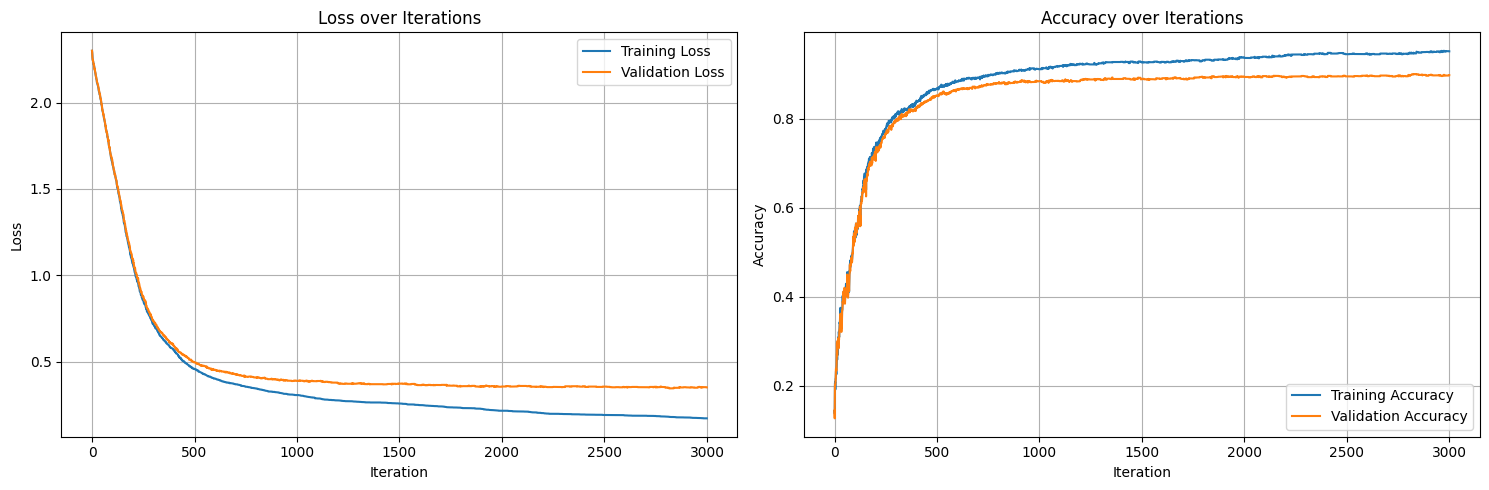

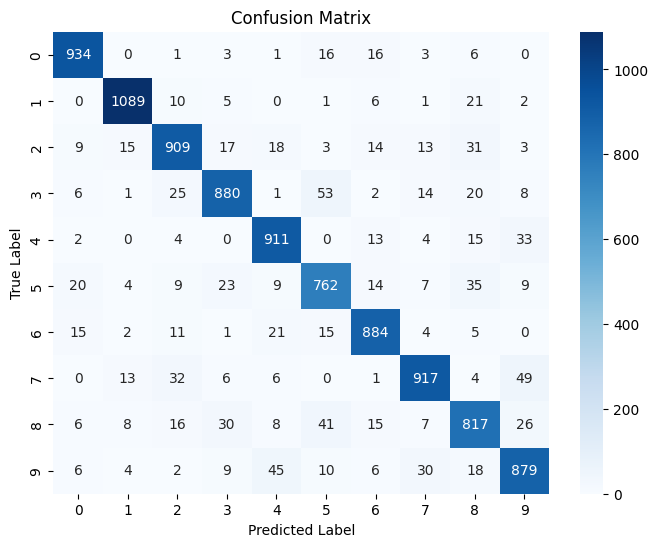

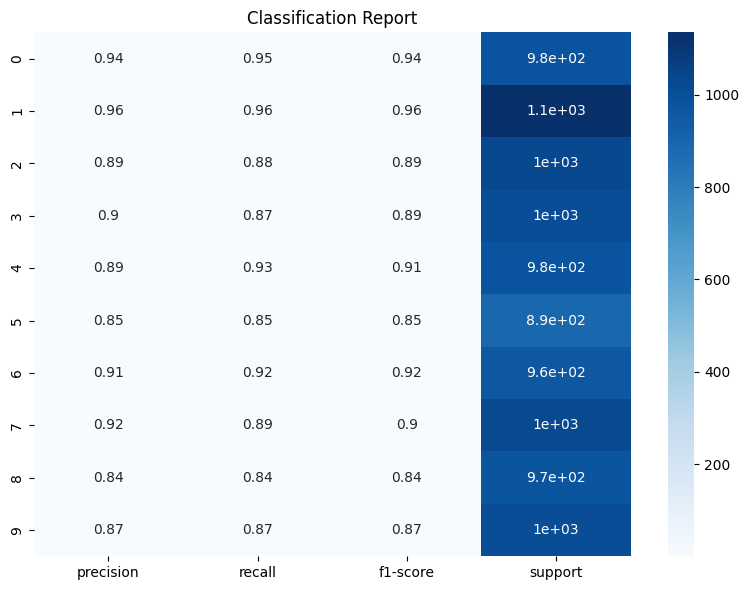

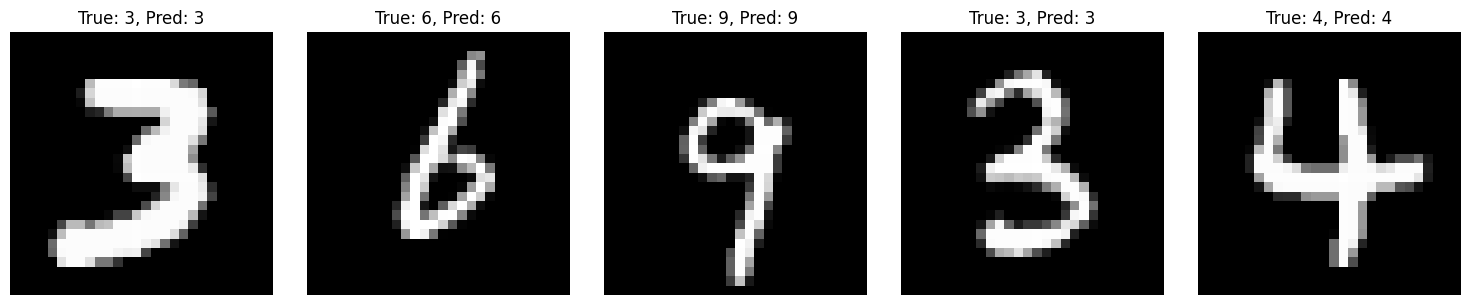

(<__main__.NeuralNetwork at 0x7fdf42b50ad0>,
 {'best_loss': 0.3456715742663298,
  'final_loss': 0.35153913032015005,
  'final_accuracy': 0.8982,
  'total_iterations': 3000,
  'execution_time': 1136.5261504650116,
  'history': {'loss': [2.299781797449739,
    2.2863255506588493,
    2.263985448400074,
    2.2481306681295354,
    2.245978579281943,
    2.238335007418516,
    2.235154921049574,
    2.2229495595736344,
    2.2229495595736344,
    2.220188412611245,
    2.213422759233667,
    2.205660632320842,
    2.1964333904370883,
    2.195619750172591,
    2.18921609777555,
    2.1824654659226215,
    2.175852770991155,
    2.1690639842725914,
    2.161194783591512,
    2.151622135903137,
    2.149980924411746,
    2.137171404861443,
    2.133909547643522,
    2.1293749953198082,
    2.1157881901238986,
    2.1137524575304236,
    2.1103057223790875,
    2.1042000271034005,
    2.101478002892987,
    2.097165592653704,
    2.0892259572566108,
    2.0849934872874747,
    2.0799399509066

In [16]:
run_genetic_algorithm()

<h1>PSO</h1>

In [17]:
class ParticleSwarmOptimization:
    def __init__(self, model, data_loader, num_particles=20, generations=3000,X=0.729, w=0.729, c1=2.05, c2=2.05, v_max=0.00525, v_min=-0.00525):
        self.model = model
        self.data_loader = data_loader
        self.num_particles = num_particles
        self.generations = generations
        self.X = X
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive weight
        self.c2 = c2  # Social weight
        self.v_max = v_max  # Maximum velocity
        self.v_min = v_min  # Minimum velocity
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def get_neighbors(self, i):
        """Get indices of neighbors in a ring topology"""
        return np.array([(i - 1) % self.num_particles, i, (i + 1) % self.num_particles])
    
    def train(self):
        """Run the PSO algorithm"""
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize swarm
        swarm = np.array([self.model.he_vector() for _ in range(self.num_particles)])
        velocities = np.random.uniform(self.v_min, self.v_max, size=swarm.shape)
        
        # Initialize personal bests
        pbest = swarm.copy()
        pbest_fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in pbest])
        
        print(f"Starting Particle Swarm Optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            for i in range(self.num_particles):
                # Find local best (ring topology)
                neighbors = self.get_neighbors(i)
                lbest_index = neighbors[np.argmin(pbest_fitness[neighbors])]
                lbest = pbest[lbest_index]
                
                # Update velocity
                r1 = np.random.rand(swarm.shape[1])
                r2 = np.random.rand(swarm.shape[1])
                velocities[i] = self.X * (
                    velocities[i]
                    + self.c1 * r1 * (pbest[i] - swarm[i])
                    + self.c2 * r2 * (lbest - swarm[i])
                )
                velocities[i] = np.clip(velocities[i], self.v_min, self.v_max)
                
                # Update position
                swarm[i] += velocities[i]
                
                # Evaluate fitness
                fit = self.model.fitness_function(swarm[i], x_train, y_train)
                if fit < pbest_fitness[i]:
                    pbest[i] = swarm[i].copy()
                    pbest_fitness[i] = fit
            
            # Find best solution
            best_idx = np.argmin(pbest_fitness)
            best_solution = pbest[best_idx]
            best_loss = pbest_fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': swarm.copy(),
                    'fitness': pbest_fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(pbest_fitness)
        best_solution = pbest[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [18]:
def run_particle_swarm_optimization():
    """Main function to run the Particle Swarm Optimization algorithm"""
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Running Neural Network with Particle Swarm Optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize PSO optimizer
    pso_optimizer = ParticleSwarmOptimization(model, data_loader, num_particles=20, generations=3000)
    
    # Train the model
    results = pso_optimizer.train()
    
    # Save the model
    model.save_model('pso_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Particle Swarm Optimization...
Starting Particle Swarm Optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.3459 - Accuracy: 0.1269
Generation 101/3000 - Best loss: 2.2752 - Accuracy: 0.1569
Generation 201/3000 - Best loss: 2.1379 - Accuracy: 0.2123
Generation 301/3000 - Best loss: 1.7404 - Accuracy: 0.4115
Generation 401/3000 - Best loss: 1.4604 - Accuracy: 0.5022
Generation 501/3000 - Best loss: 1.2398 - Accuracy: 0.5823
Generation 601/3000 - Best loss: 1.0582 - Accuracy: 0.6463
Generation 701/3000 - Best loss: 0.9187 - Accuracy: 0.6869
Generation 801/3000 - Best loss: 0.8039 - Accuracy: 0.7256
Generation 901/3000 - Best loss: 0.7200 - Accuracy: 0.7547
Generation 1001/3000 - Best loss: 0.6560 - Accuracy: 0.7774
Generation 1101/3000 - Best loss: 0.5998 - Accuracy: 0.7933
Generation 1201/3000 - Best loss: 0.5584 - Accuracy: 0.8080
Generation 1301/3000 - Best loss: 0.5226 - Accuracy: 0.8167
Generation 1401/3000 - Best loss: 0.4925 - Accuracy:

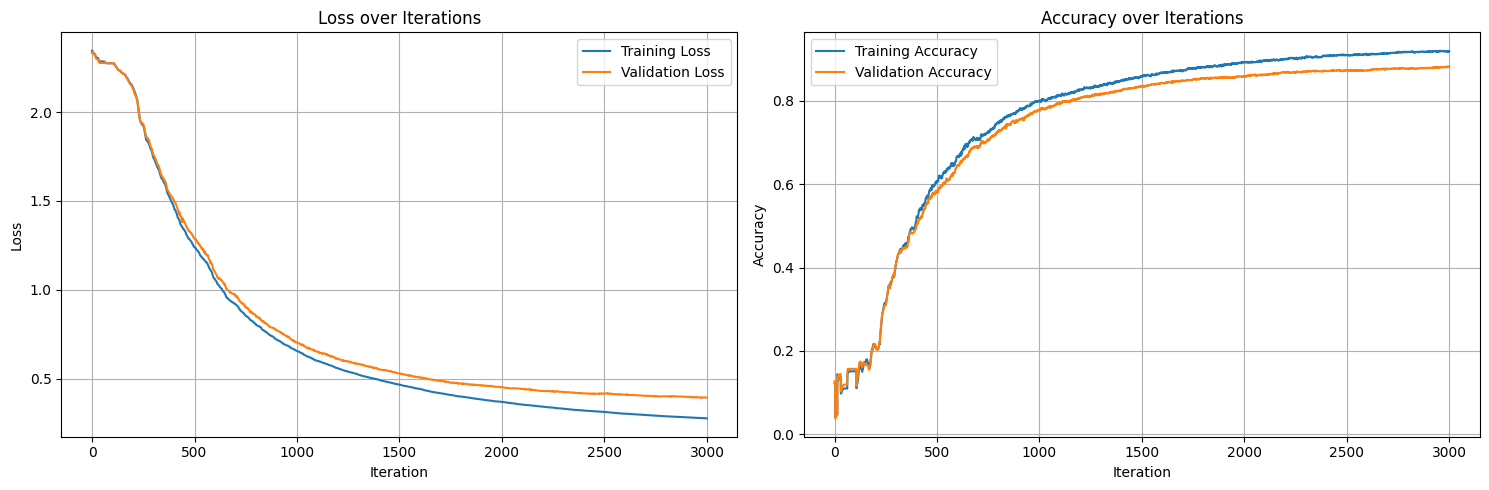

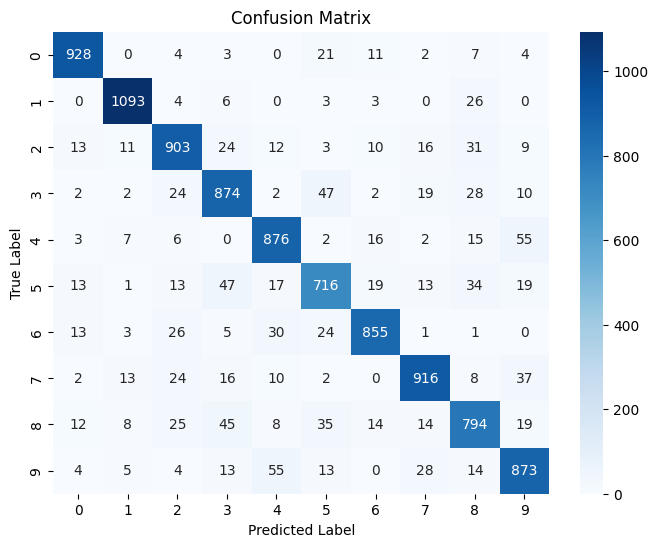

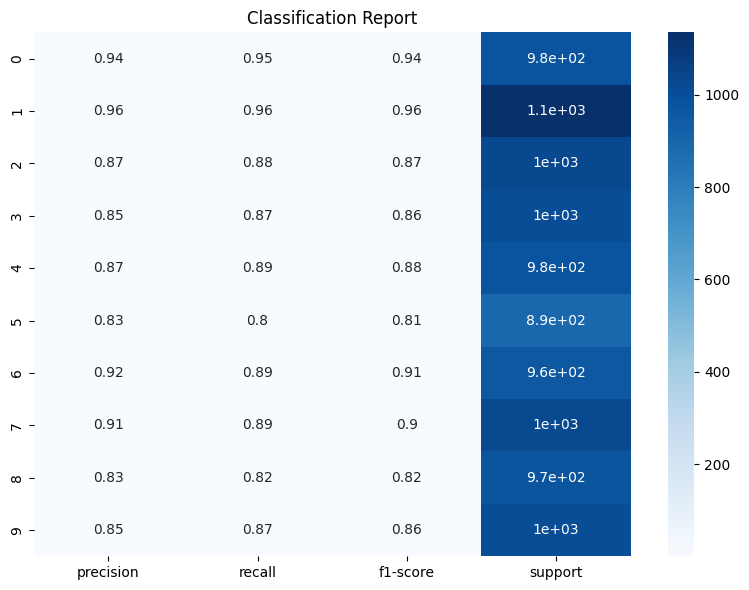

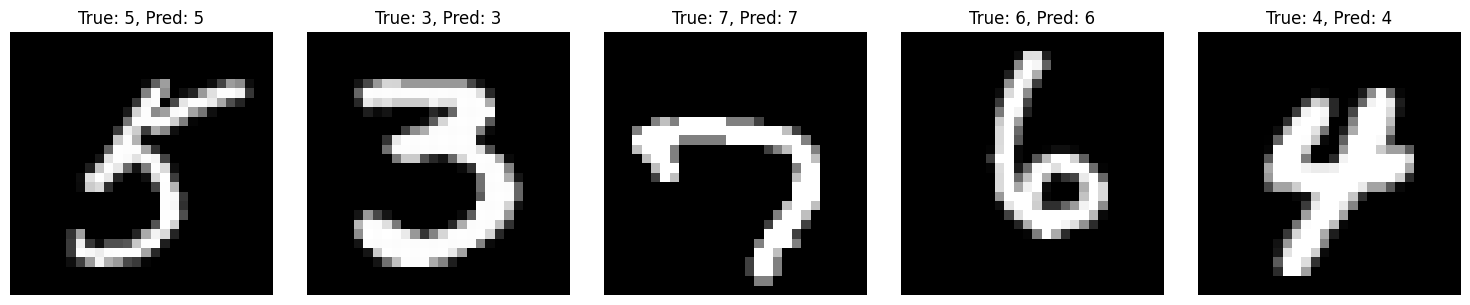

(<__main__.NeuralNetwork at 0x7fdf43147ed0>,
 {'best_loss': 0.39289148197616475,
  'final_loss': 0.39320157311654536,
  'final_accuracy': 0.8828,
  'total_iterations': 3000,
  'execution_time': 1127.14568400383,
  'history': {'loss': [2.3458542942186336,
    2.3452399432882296,
    2.3447581338714594,
    2.3445830764348177,
    2.340790356409499,
    2.3368331890377667,
    2.3342580660928802,
    2.332524721849516,
    2.3313267214884217,
    2.3304967810267074,
    2.329897724975102,
    2.3294678440675383,
    2.328874646901414,
    2.326380671460981,
    2.324190817295617,
    2.3215878901623372,
    2.319745845258145,
    2.3169701510895764,
    2.313368967362066,
    2.3108718409808793,
    2.309101829785626,
    2.3078510929386087,
    2.3069552856275863,
    2.3063114750673317,
    2.305844408272138,
    2.3055067502526194,
    2.305262107292273,
    2.3050852423366104,
    2.3049566083136903,
    2.304863104456884,
    2.304795042398401,
    2.301781053424181,
    2.294949369

In [19]:
run_particle_swarm_optimization()

<h1>Hybrid(GA -> DE)</h1>

In [20]:
def run_hybrid_ga_de():
    model, results = run_genetic_algorithm()
    population = results['final_population']
    fitness = results['final_fitness'] 
    run_differential_evolution(population, fitness)

Running Neural Network with Genetic Algorithm optimization...
Starting Genetic Algorithm optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.2998 - Accuracy: 0.1443
Generation 101/3000 - Best loss: 1.6404 - Accuracy: 0.5558
Generation 201/3000 - Best loss: 1.0601 - Accuracy: 0.7096
Generation 301/3000 - Best loss: 0.7176 - Accuracy: 0.7934
Generation 401/3000 - Best loss: 0.5656 - Accuracy: 0.8237
Generation 501/3000 - Best loss: 0.4577 - Accuracy: 0.8526
Generation 601/3000 - Best loss: 0.4025 - Accuracy: 0.8659
Generation 701/3000 - Best loss: 0.3697 - Accuracy: 0.8701
Generation 801/3000 - Best loss: 0.3457 - Accuracy: 0.8797
Generation 901/3000 - Best loss: 0.3237 - Accuracy: 0.8824
Generation 1001/3000 - Best loss: 0.3070 - Accuracy: 0.8846
Generation 1101/3000 - Best loss: 0.2875 - Accuracy: 0.8847
Generation 1201/3000 - Best loss: 0.2762 - Accuracy: 0.8869
Generation 1301/3000 - Best loss: 0.2682 - Accuracy: 0.8874
Generation 1401/3000 - Best loss: 0.2642 - Acc

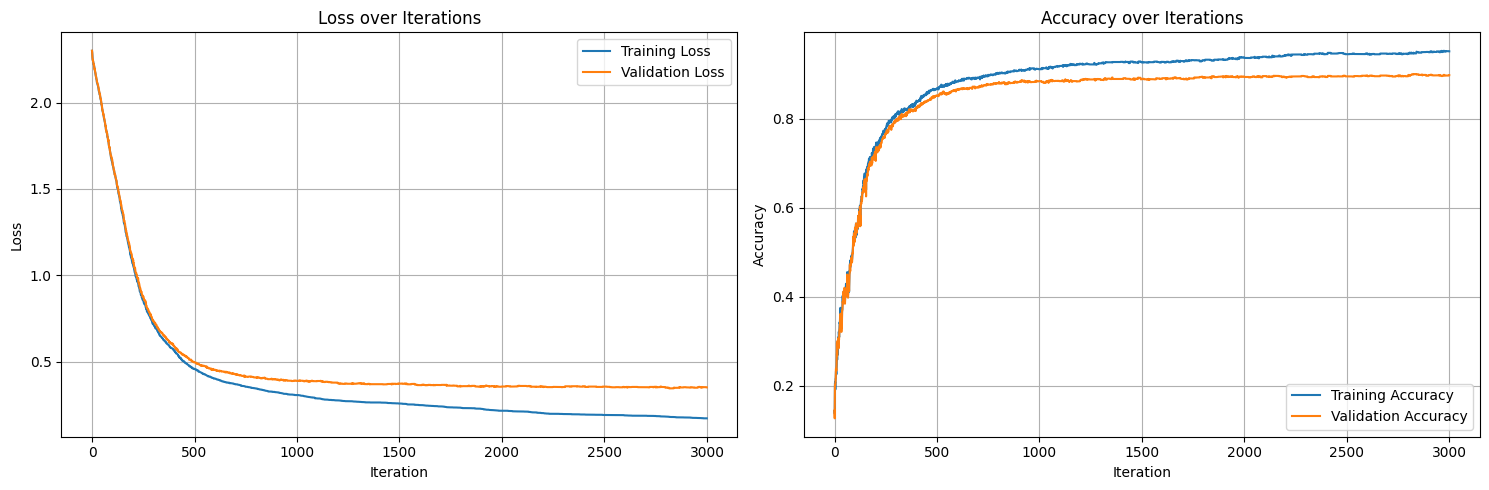

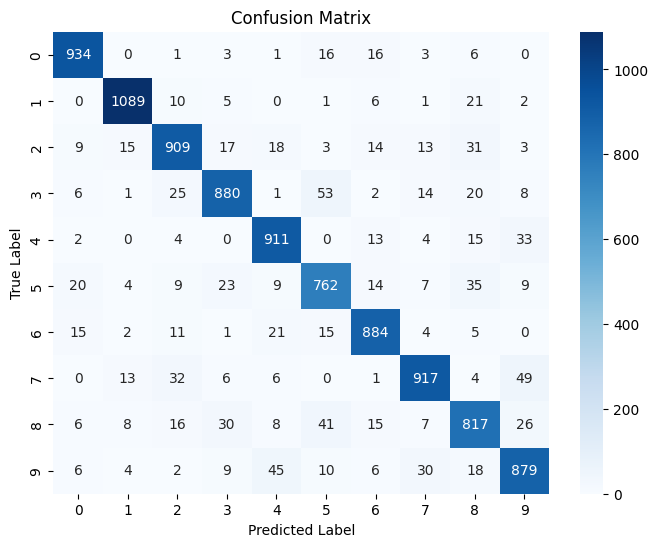

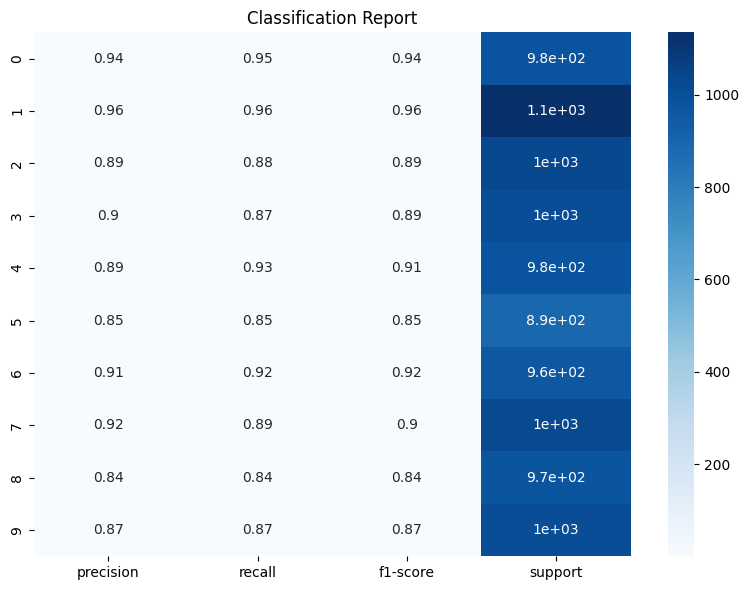

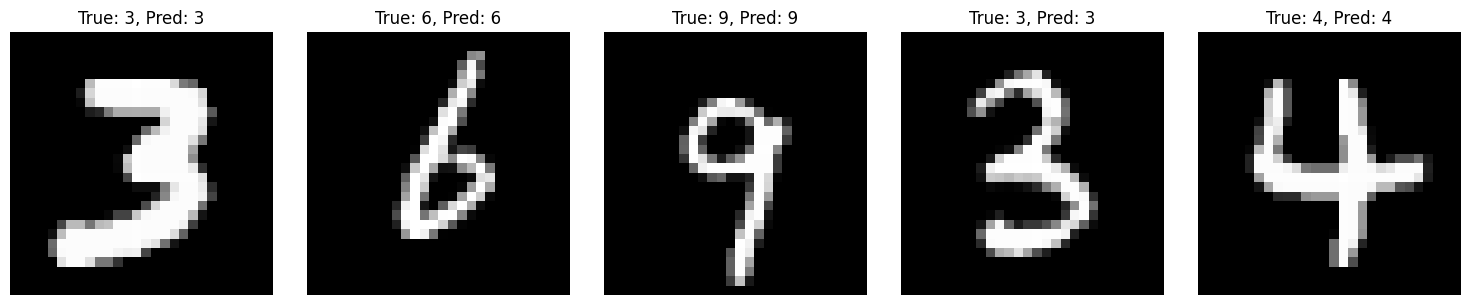

Running Neural Network with Differential Evolution optimization...
Starting Differential Evolution for 3000 generations...
Generation 1/3000 - Best loss: 0.1724 - Accuracy: 0.8982
Generation 101/3000 - Best loss: 0.1665 - Accuracy: 0.8997
Generation 201/3000 - Best loss: 0.1616 - Accuracy: 0.8998
Generation 301/3000 - Best loss: 0.1577 - Accuracy: 0.9003
Generation 401/3000 - Best loss: 0.1546 - Accuracy: 0.9000
Generation 501/3000 - Best loss: 0.1510 - Accuracy: 0.9011
Generation 601/3000 - Best loss: 0.1477 - Accuracy: 0.9013
Generation 701/3000 - Best loss: 0.1448 - Accuracy: 0.9030
Generation 801/3000 - Best loss: 0.1418 - Accuracy: 0.9035
Generation 901/3000 - Best loss: 0.1396 - Accuracy: 0.9040
Generation 1001/3000 - Best loss: 0.1376 - Accuracy: 0.9052
Generation 1101/3000 - Best loss: 0.1357 - Accuracy: 0.9057
Generation 1201/3000 - Best loss: 0.1337 - Accuracy: 0.9043
Generation 1301/3000 - Best loss: 0.1316 - Accuracy: 0.9063
Generation 1401/3000 - Best loss: 0.1300 - Accura

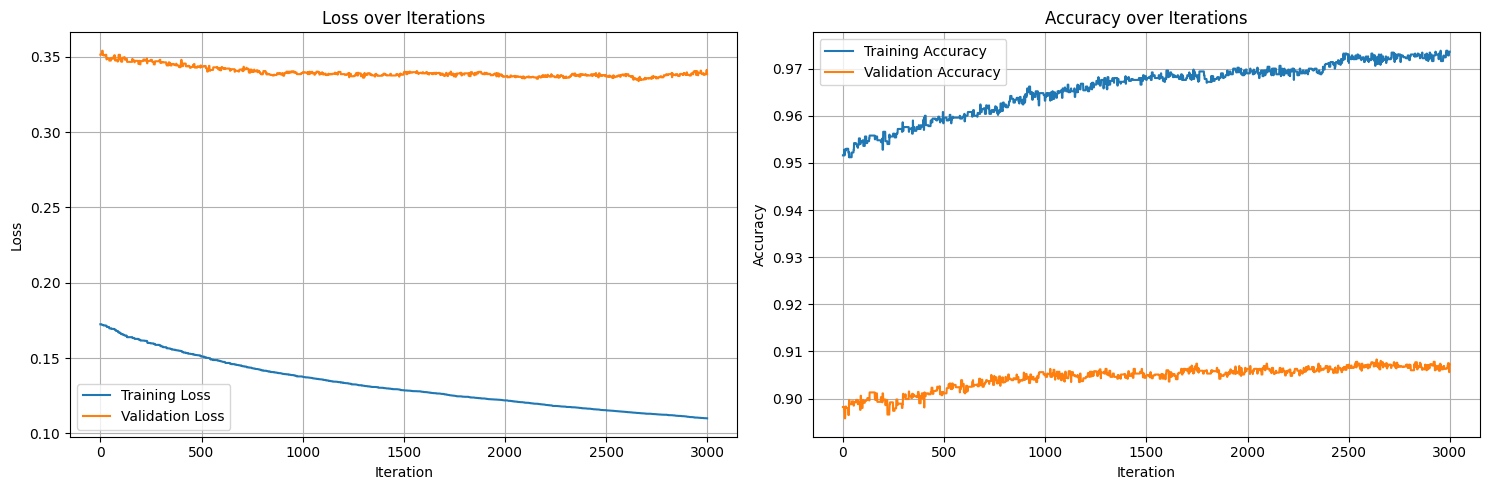

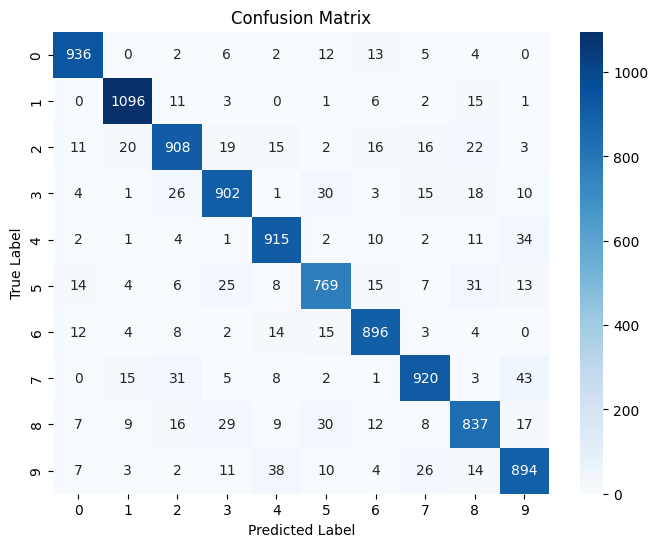

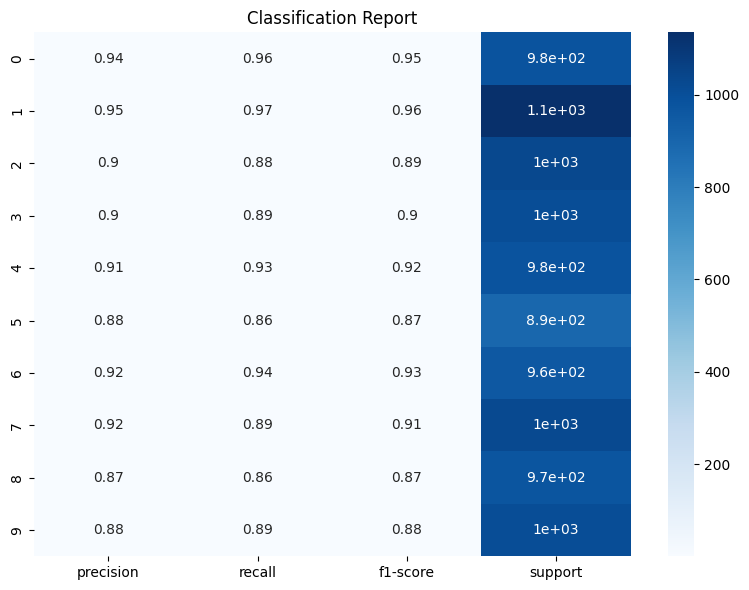

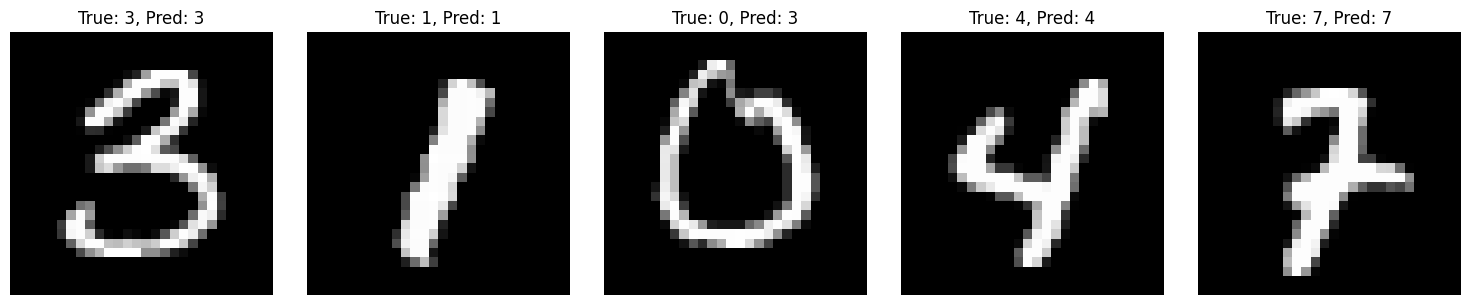

In [21]:
run_hybrid_ga_de()